In [15]:
# ============================================================
# 📦 1. Setup & Imports
# ============================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
import joblib

# Optional: mount Google Drive if dataset is stored there
# from google.colab import drive
# drive.mount('/content/drive')


In [16]:
# ============================================================
# ⚙️ 2. Configuration & Load Dataset
# ============================================================
RANDOM_STATE = 42
TEST_SIZE = 0.25

# ⬇️ change the path below to your uploaded CSV in Colab
DATA_PATH = '/content/customerchurn_dataset.csv'

OUTPUT_DIR = '/content/output_files'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the dataset
df = pd.read_csv(DATA_PATH)
print("✅ Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())


✅ Loaded dataset: /content/customerchurn_dataset.csv
Shape: (12892, 22)


,recordID,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,customer_id
0,1,HI,101,510,no,no,0,70.9,123,12.05,...,18.01,236.0,73,10.62,10.6,3,2.86,3,no,23383607.0
1,2,MT,137,510,no,no,0,223.6,86,38.01,...,20.81,94.2,81,4.24,9.5,7,2.57,0,no,22550362.0
2,3,OH,103,408,no,yes,29,294.7,95,50.10,...,20.17,300.3,127,13.51,13.7,6,3.70,1,no,59063354.0
3,4,NM,99,415,no,no,0,216.8,123,36.86,...,10.74,220.6,82,9.93,15.7,2,4.24,1,no,25464504.0
4,5,SC,108,415,no,no,0,197.4,78,33.56,...,10.54,204.5,107,9.20,7.7,4,2.08,2,no,691824.0


In [17]:
# ============================================================
# 🔍 3. Identify Target Column & Basic EDA
# ============================================================

# Detect target column automatically
target_candidates = ['churn', 'Churn', 'target', 'label']
target = next((t for t in target_candidates if t in df.columns), df.columns[-1])

print("Detected target column:", target)
print("\nTarget value counts:")
display(df[target].value_counts(dropna=False))

print("\n--- Dataset Info ---")
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\nNumeric Summary (first 10 features):")
display(df.select_dtypes(include=[np.number]).describe().T.head(10))


Detected target column: churn

Target value counts:


,count
churn,
no,11069
yes,1823



--- Dataset Info ---
Columns: ['recordID', 'state', 'account_length', 'area_code', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'churn', 'customer_id']

Missing values per column:
recordID                         0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls         

,count,mean,std,min,25%,50%,75%,max
recordID,12892.0,6446.500000,3721.744170,1.0,3223.75,6446.500,9669.25,12892.00
account_length,12892.0,100.676621,39.806413,1.0,73.00,100.000,127.00,243.00
area_code,12892.0,437.133804,42.341820,408.0,408.00,415.000,510.00,510.00
number_vmail_messages,12892.0,7.996665,13.641977,0.0,0.00,0.000,19.00,52.00
total_day_minutes,12892.0,180.162023,54.207056,0.0,144.00,180.000,216.30,351.50
total_day_calls,12892.0,100.266599,19.946657,0.0,87.00,101.000,114.00,165.00
total_day_charge,12892.0,30.628086,9.215171,0.0,24.48,30.600,36.77,59.76
total_eve_minutes,12892.0,200.711852,50.781851,0.0,166.20,201.150,234.90,363.70
total_eve_calls,12892.0,100.137139,19.894032,0.0,87.00,100.000,114.00,170.00
total_eve_charge,12892.0,17.060717,4.316445,0.0,14.13,17.095,19.97,30.91


In [18]:
# ============================================================
# 🧹 4. Feature Preparation & Train/Test Split
# ============================================================

X = df.drop(columns=[target]).copy()
for idcol in ['recordID', 'customer_id', 'id', 'phone_number', 'phone']:
    if idcol in X.columns:
        X.drop(columns=[idcol], inplace=True)

y = df[target].copy()

# Encode target to 0/1
if y.dtype == object:
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=target)
else:
    if not set(y.unique()).issubset({0,1}):
        y = (y != 0).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (9669, 19)  Test shape: (3223, 19)


In [19]:
# ============================================================
# 🧪 5. Preprocessing Pipelines
# ============================================================

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Numeric columns: ['account_length', 'area_code', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']
Categorical columns: ['state', 'international_plan', 'voice_mail_plan']


In [20]:
# ============================================================
# 🤖 6. Train Models
# ============================================================

rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

print("✅ Training complete.")


Training Random Forest...
Training Logistic Regression...
✅ Training complete.


In [21]:
# ============================================================
# 📊 7. Evaluation Helper Function
# ============================================================
def evaluate_model(pipeline, X_test, y_test, model_name="Model"):
    preds = pipeline.predict(X_test)
    proba = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline.named_steps['clf'], 'predict_proba') else None

    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, preds))

    if proba is not None:
        auc = roc_auc_score(y_test, proba)
        print(f"{model_name} ROC AUC: {auc:.4f}")
    else:
        auc = None

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # ROC curve
    if proba is not None:
        fpr, tpr, _ = roc_curve(y_test, proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()
        plt.show()
    return preds, proba



--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2767
           1       1.00      0.98      0.99       456

    accuracy                           1.00      3223
   macro avg       1.00      0.99      0.99      3223
weighted avg       1.00      1.00      1.00      3223

Random Forest ROC AUC: 0.9971


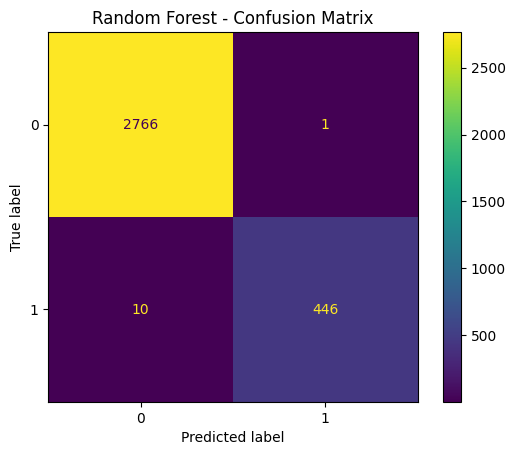

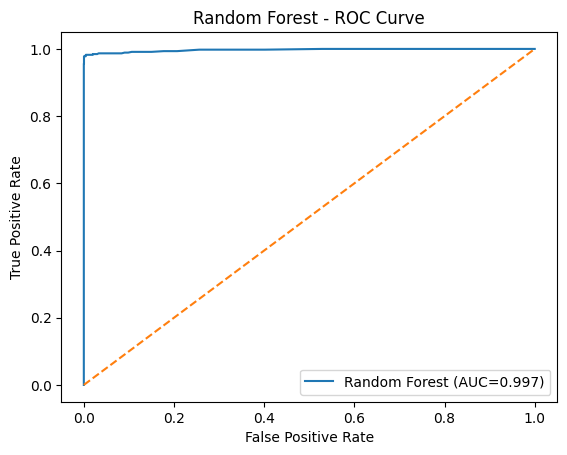


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2767
           1       0.51      0.21      0.30       456

    accuracy                           0.86      3223
   macro avg       0.70      0.59      0.61      3223
weighted avg       0.83      0.86      0.83      3223

Logistic Regression ROC AUC: 0.8242


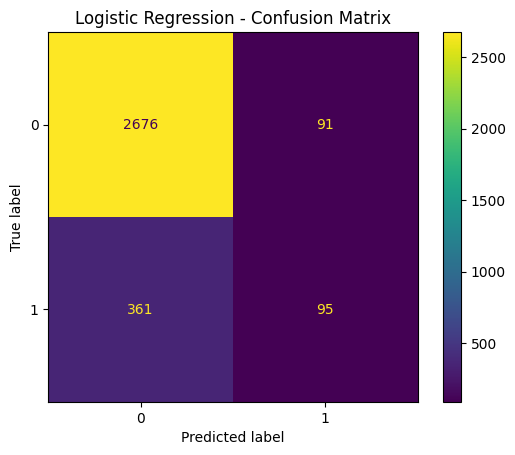

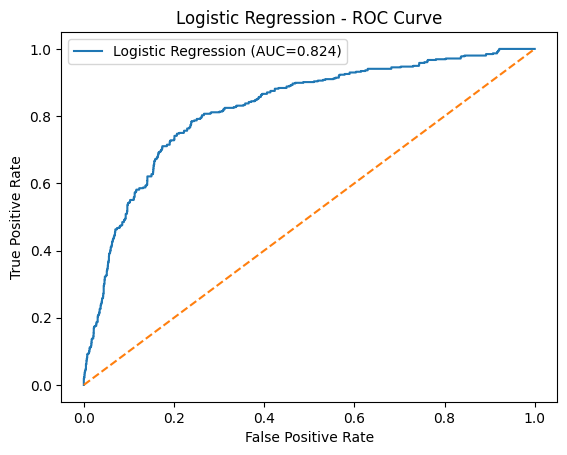

In [22]:
# ============================================================
# 🧾 8. Evaluate Both Models
# ============================================================
rf_preds, rf_proba = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")
lr_preds, lr_proba = evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression")



Top 20 Important Features:


,feature,importance
3,total_day_minutes,0.129707
5,total_day_charge,0.128932
15,number_customer_service_calls,0.107046
6,total_eve_minutes,0.057773
8,total_eve_charge,0.054276
13,total_intl_calls,0.049751
68,international_plan__yes,0.046119
67,international_plan__no,0.043227
12,total_intl_minutes,0.042380
14,total_intl_charge,0.040432


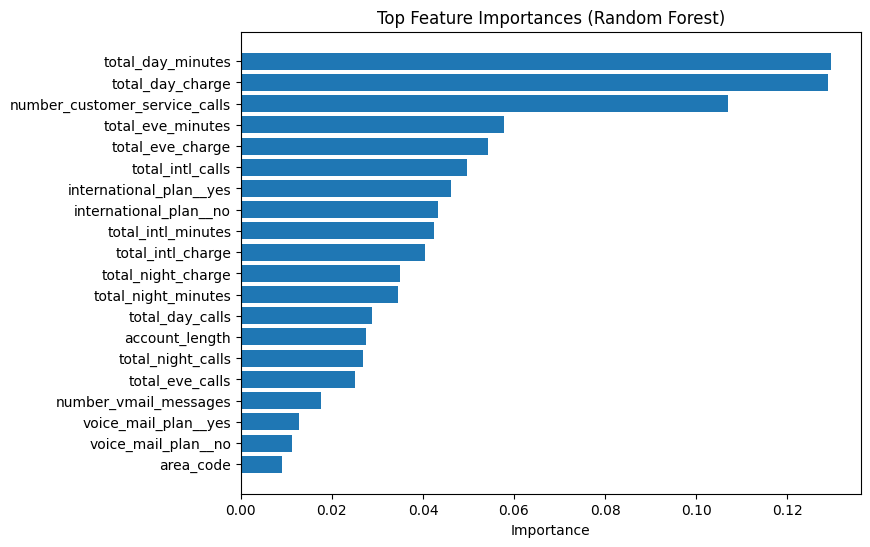

In [23]:
# ============================================================
# 🔍 9. Feature Importance (Random Forest)
# ============================================================

feature_names = []
if num_cols:
    feature_names.extend(num_cols)
if cat_cols:
    ohe = rf_pipeline.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    cats = ohe.categories_
    for col, cat_values in zip(cat_cols, cats):
        for val in cat_values:
            feature_names.append(f"{col}__{val}")

if hasattr(rf_pipeline.named_steps['clf'], 'feature_importances_'):
    importances = rf_pipeline.named_steps['clf'].feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(20)
    print("\nTop 20 Important Features:")
    display(imp_df)
    plt.figure(figsize=(8,6))
    plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
    plt.title('Top Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.show()


In [24]:
# ============================================================
# 💾 10. Save Trained Pipelines
# ============================================================
joblib.dump(rf_pipeline, os.path.join(OUTPUT_DIR, 'random_forest_pipeline.pkl'))
joblib.dump(lr_pipeline, os.path.join(OUTPUT_DIR, 'logistic_regression_pipeline.pkl'))

print("✅ Pipelines saved to:", OUTPUT_DIR)


✅ Pipelines saved to: /content/output_files


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# ============================================================
# 🗂️ 11. Optional: Save Text Reports
# ============================================================

rf_report = classification_report(y_test, rf_preds, output_dict=True)
lr_report = classification_report(y_test, lr_preds, output_dict=True)
summary = {
    'rf_auc': roc_auc_score(y_test, rf_proba) if rf_proba is not None else None,
    'lr_auc': roc_auc_score(y_test, lr_proba) if lr_proba is not None else None
}

pd.DataFrame(rf_report).T.to_csv(os.path.join(OUTPUT_DIR, 'rf_classification_report.csv'))
pd.DataFrame(lr_report).T.to_csv(os.path.join(OUTPUT_DIR, 'lr_classification_report.csv'))
pd.DataFrame([summary]).to_csv(os.path.join(OUTPUT_DIR, 'auc_summary.csv'), index=False)

print("Reports saved to:", OUTPUT_DIR)


Reports saved to: /content/output_files
